### Required Libraries
- qgrid to display tables interactively
    - run following two commands in order to enable qgrid
    - pip install qgrid
    - jupyter nbextension enable --py --sys-prefix qgrid
- seaborn for visualization
    - pip install seaborn
- nltk for simple nlp tasks
    - pip install nltk
    - you may need to downlaod its data using nltk.download()

In [6]:
import pandas as pd
import qgrid
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np
sns.set_style("ticks")
sns.set_style("whitegrid")

In [7]:
df = pd.read_csv("../dataset/A Sociolinguistic Study_May 4, 2019_18.52.csv", skiprows=3)

In [9]:
useful_columns = list(df.columns[17:34]) + list(df.columns[55:76])

In [11]:
qgrid_widget = qgrid.show_grid(df[useful_columnbs[30:40]], show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [12]:
useful_columns

['birth_year',
 'is_us_born',
 'parents_us_born',
 'parents_state',
 'parents_degree',
 'is_homeschooled',
 'gpa',
 'school_year',
 'ideal_degree',
 'is_grad_seeking',
 'grad_if_job_offer',
 'gender_pronoun',
 'sexual_orient',
 'political_identity',
 'for_group',
 'against_group',
 'undecided_group',
 'news_hour',
 'news_source',
 'is_vote_important',
 'news_reliabality',
 'politics_rank',
 'sports_rank',
 'crime_rank',
 'local_news_rank',
 'world_news_rank',
 'entertainment_rank',
 'news_informability',
 'vote_eligibility',
 'did_vote',
 'voted_for_candidate',
 'will_vote_2020',
 '2016_feeling',
 '2016_atmosphere',
 'feeling_1',
 'feeling_2',
 'feeling_3',
 'rhetoric_question']

In [13]:
df['2016_feeling'].head()

0    I was upset and angry about the election of so...
1    i don't care about politics and think it is al...
2    I feel like the country will see a change rega...
3    Very happy with the turnout. Not so much for t...
4    I feel surprised, but glad that Hillary Clinto...
Name: 2016_feeling, dtype: object

In [14]:
def word_count(text):
    return len(text.split())

In [18]:
df['word_count'] = df['2016_feeling'].apply(word_count) + df['2016_atmosphere'].apply(word_count)

In [19]:
df['word_count'].describe()

count    185.000000
mean      77.200000
std       38.537503
min        2.000000
25%       51.000000
50%       67.000000
75%       93.000000
max      237.000000
Name: word_count, dtype: float64

In [22]:
len(df)

185

### Visualization1: 
- Distribution of GPA for different groups.
- Following figure is the summary distribution of students' gpa for two groups: homeschooled students vs non-homeschooled students.
- As figure below illustrates, those who were homeschooled are more successful in obtaining higher GPA.

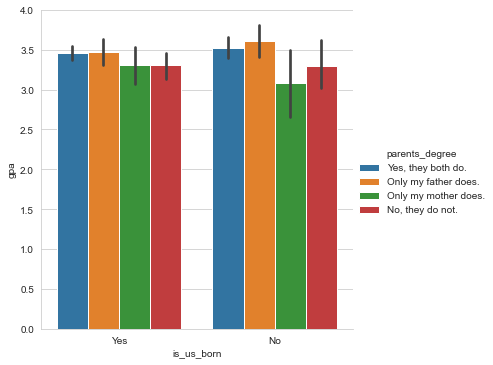

In [5]:
sns.catplot(x="is_us_born", y="gpa", hue="parents_degree", kind="bar", data=df);

In [ ]:
sns.boxplot(x='is_homeschooled',y='gpa', data=df)

In [ ]:
sns.boxplot(x='gpa',y='gender_pronoun', data=df)

### Finding the tense
- find verb tenses based on https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
- nltk.word_tokenize converts string to a list of words (i.e., tokens).
- nltk.pos_tag converts the list of tokens to a list of tokens and their associated parts of speech.

In [29]:
past_tense_tags = ['VBD']
present_tense_tags = ['VBP', 'VBZ']
political_id_to_tense = {}
for pol_id, feeling in zip(df['political_identity'], df['2016_atmosphere']):
    print(feeling)
    break
    past_tense_count = 0
    present_tense_count = 0
    tokens = nltk.word_tokenize(feeling)
    pos = nltk.pos_tag(tokens)
    for pair in pos:
        if pair[1] in past_tense_tags:
            past_tense_count += 1
        if pair[1] in present_tense_tags:
            present_tense_count += 1
    if pol_id not in political_id_to_tense:
        political_id_to_tense[pol_id] = {'past_tense': past_tense_count, 'present_tense': present_tense_count}
    else:
        political_id_to_tense[pol_id]['past_tense'] += past_tense_count
        political_id_to_tense[pol_id]['present_tense'] += present_tense_count

My friends were angry and distressed about the world of a Donald Trump presidency. I am watching the election results come in at a friend's apartment.


In [30]:
political_id_to_tense

{}

In [31]:
for party, count in political_id_to_tense.items():
    party_past = political_id_to_tense[party]['past_tense'] / sum(count.values())
    party_present = political_id_to_tense[party]['present_tense'] / sum(count.values())
    print('%.2f%% verbs %ss used were past tense and %.2f%% verbs were present tense.' % (party_past * 100, party, party_present * 100))

### Observations:
- The above approach is not accurate. We shouldn't count all verb tenses.
- We should detect the tense per sentence which is tricky because a sentence may contain several verbs, modals, auxiliary verbs, etc. and/or have complex structure. 
- The best solution is to train a classifier for a binary (past/present) classification task.
- There is a dataset called TimeBank that might be useful but it needs licensing (https://catalog.ldc.upenn.edu/LDC2006T08).
- It's free so I registered to access the dataset but the process may take long.
- Alternatvely, we can find the root verb (using Stanford parser) and assign its parts of speech tag to the whole sentence:
    - To start Stanofrd CoreNLP:
        - Download the package from: https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip
        - navigate to the base directory and issue the following command: 
         `java -mx3g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -timeout 5000`
        - install pycorenlp package: pip install pycorenlp

In [2]:
from pycorenlp import StanfordCoreNLP

In [54]:
nlp = StanfordCoreNLP('http://localhost:9000')

In [55]:
# test_text = "about the world of a Donald Trump presidency."
# test_text = "I had certainly thought that he was going to win"
test_text = "If it were any other individual I would have voted Democrat."
# test_text = "Lots of upset women over donald trump being president and people thinking they will be deported."

In [87]:
import json
result = nlp.annotate(test_text, properties={'annotators': 'sentiment, pos', 'outputFormat': 'JSON'})
result = json.loads(result)

In [88]:
print(result['sentences'][0]['sentiment'])

Negative


### How to find the root verb from parse tree?
- can we say root verb is the one closer to the ROOT of the parse tree?

In [89]:
from nltk.tree import Tree
parsetree = Tree.fromstring(result['sentences'][0]['parse'])
parsetree.pretty_print()

                              ROOT                                             
                               |                                                
                               S                                               
          _____________________|_____________________________________________   
        SBAR                           |              VP                     | 
  _______|____                         |     _________|____                  |  
 |            S                        |    |              VP                | 
 |    ________|___                     |    |     _________|____             |  
 |   |            VP                   |    |    |              VP           | 
 |   |    ________|____                |    |    |          ____|_____       |  
 |   NP  |             NP              NP   |    |         |          NP     | 
 |   |   |     ________|_______        |    |    |         |          |      |  
 IN PRP VBD   DT       JJ      JJ 

In [101]:
parsetree.draw()

#### Traverse the tree:

In [102]:
root_verb = []
modal_tag = None
def traverse_tree(tree):
    global root_verb
    global modal_tag
    for subtree in tree:
        if type(subtree) == nltk.tree.Tree:
            if subtree.label() == 'VP':
                if subtree.pos()[0][1] == 'VB':
                    if subtree.pos()[0][0] == 'have':
                        traverse_tree(subtree)
                    if modal_tag in ['could', 'would', 'might', 'had to']:
                        root_verb.append((subtree.pos()[0][0], 'VBD'))
                        modal_tag = None
                        break
                    elif modal_tag in ['can', 'must', 'will', 'may', 'should', 'have to', 'shall', 'ought to']:
                        root_verb.append((subtree.pos()[0][0], 'VBP'))
                        modal_tag = None
                        break
                    traverse_tree(subtree)
                elif subtree.pos()[0][1] == 'VBN':
                    if modal_tag in ['must', 'could', 'should', 'may', 'might', 'would']:
                        root_verb.append((subtree.pos()[0][0], 'VBD'))
                        modal_tag = None
                        break
                elif subtree.pos()[0][1] == 'VBD':
                    root_verb.append((subtree.pos()[0][0], 'VBD'))
                    break
                elif subtree.pos()[0][1] == 'VBZ' or subtree.pos()[0][1] == 'VBP':
                    if modal_tag in ['could', 'would', 'might', 'had to']:
                        root_verb.append((subtree.pos()[0][0], 'VBD'))
                        modal_tag = None
                        break
                    else:
                        root_verb.append((subtree.pos()[0][0], 'VBP'))
                        break
                elif subtree.pos()[0][1] == 'MD':
                    modal_tag = subtree.pos()[0][0]
                    traverse_tree(subtree)
            traverse_tree(subtree)

In [173]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [103]:
traverse_tree(parsetree)
root_verb

[('were', 'VBD'), ('voted', 'VBD')]

### Putting it all together

In [105]:
total_tense = []
for atmosphere, feeling in zip(df['2016_atmosphere'], df['2016_feeling']):
    root_verb = []
    result = nlp.annotate(atmosphere, properties={'annotators': 'sentiment, pos', 'outputFormat': 'json'})
    result = json.loads(result)
    for sentence in result['sentences']:
        parsetree = Tree.fromstring(sentence['parse'])
        traverse_tree(parsetree)
    result = nlp.annotate(feeling, properties={'annotators': 'sentiment, pos', 'outputFormat': 'json'})
    result = json.loads(result)
    for sentence in result['sentences']:
        parsetree = Tree.fromstring(sentence['parse'])
        traverse_tree(parsetree)
    total_tense.append(root_verb)

In [106]:
df['total_tense'] = total_tense

In [107]:
qgrid_widget = qgrid.show_grid(df[['2016_atmosphere', '2016_feeling', 'total_tense']], show_toolbar=True)
qgrid_widget


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Observations:
- I think this approach yeilds a better result
- MD tag (modal) is very common and it could mean both past or present (TODO) -> Done
- We should address RB tag (adverb), we should address adverbs in the tree traverse (TODO) -> Done
- I also added VB tag (base form of the verb) to the present tense.

Now we have to decide how to convert sentence tense to a measure:
- Content of the feeling column could have multiple sentences. How to decide which tense the student is using?
- Several options:
    1. option1) Majority tense if no major tense, pick the last tense 
    2. option2) Undefined -> yields to too many unknowns!
    3. option3) Considering the temporal inconsistency (choices of different verb tenses in the sentences of a single narrative) as a seperate measure i.e. the brokenness of the narrative. 
    4. option4) measure the ratio of present over past
    5. option5) identify the sentiment

In [182]:
# #option4

# ratio_list = []
# ratio_list_inverse = []
# for tense_list in df['total_tense']:
#     past_count = 0.0
#     present_count = 0.0
#     for tense in tense_list:
#         if tense[1] == 'VBD' or tense[1] == 'VBN':
#             past_count += 1
#         if tense[1] == 'VBP' or tense[1] == 'VPZ':
#             present_count += 1
#     if past_count + present_count == 0:
#         ratio_list.append(0)
#         ratio_list_inverse.append(0)
#     else:
#         ratio_list.append((present_count) / (past_count + present_count))
#         ratio_list_inverse.append((past_count) / (past_count + present_count))

In [189]:
#option4

past_count_list = []
present_count_list = []
for tense_list in df['total_tense']:
    past_count = 0.0
    present_count = 0.0
    for tense in tense_list:
        if tense[1] == 'VBD' or tense[1] == 'VBN':
            past_count += 1
        if tense[1] == 'VBP' or tense[1] == 'VPZ':
            present_count += 1
    past_count_list.append(past_count)
    present_count_list.append(present_count)
#     if past_count + present_count == 0:
#         ratio_list.append(0)
#         ratio_list_inverse.append(0)
#     else:
#         ratio_list.append((present_count) / (past_count + present_count))
#         ratio_list_inverse.append((past_count) / (past_count + present_count))

In [190]:
df['past_count'] = past_count_list

In [191]:
df['present_count'] = present_count_list

In [192]:
past_count_mean = df['past_count'].mean()

In [194]:
past_count_std = df['past_count'].std()

In [196]:
present_count_mean = df['present_count'].mean()

In [197]:
present_count_std = df['present_count'].std()

In [198]:
present_count_normal = [(x-present_count_mean)/present_count_std for x in present_count_list]

In [199]:
past_count_normal = [(x-past_count_mean)/past_count_std for x in past_count_list]

In [200]:
df['present2past'] = [x/y for x, y in zip(present_count_normal, past_count_normal)]

In [201]:
lr = df[df['political_identity'] == 'Liberal']['present2past']

In [202]:
cr = df[df['political_identity'] == 'Conservative']['present2past']

In [184]:
df['pr_total_ratio'] = ratio_list
#df['pa_total_ratio'] = ratio_list_inverse

In [185]:
lr = df[df['political_identity'] == 'Liberal']['pr_total_ratio']
lr_sorted = np.sort(lr)
plr = 1. * np.arange(len(lr)) / (len(lr) - 1)

cr = df[df['political_identity'] == 'Conservative']['pr_total_ratio']
cr_sorted = np.sort(cr)
pcr = 1. * np.arange(len(cr)) / (len(cr) - 1)

otr = df[df['political_identity'] == 'Other']['pr_total_ratio']
otr_sorted = np.sort(otr)
potr = 1. * np.arange(len(otr)) / (len(otr) - 1)

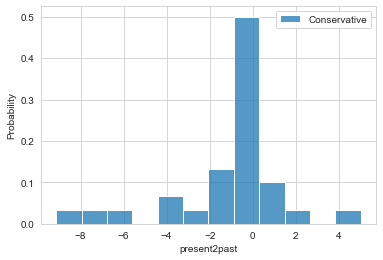

In [203]:
fig, ax = plt.subplots()
# sns.histplot(lr, label='Liberal')
sns.histplot(cr, label='Conservative', stat="probability")
plt.legend()
plt.show()

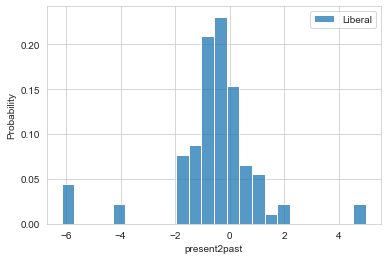

In [204]:
fig, ax = plt.subplots()
sns.histplot(lr, label='Liberal', stat="probability")
# sns.histplot(cr, label='Conservative')
plt.legend()
plt.show()

In [144]:
import numpy as np
x = np.random.randn(100)

/home/saed/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

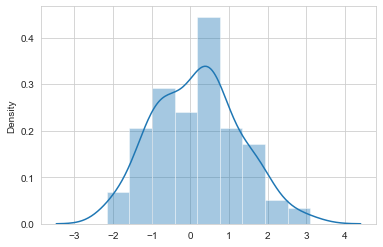

In [146]:
sns.distplot(x)

/home/saed/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/saed/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


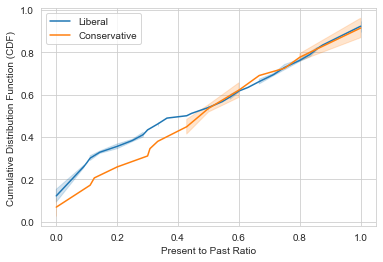

In [160]:
fig, ax = plt.subplots()
sns.lineplot(tuple(lr_sorted), plr, ax=ax, label='Liberal')
sns.lineplot(tuple(cr_sorted), pcr, ax=ax, label='Conservative')
# sns.lineplot(tuple(otr_sorted), potr, ax=ax, label='Other')
# ax.set_yscale('log')
# plt.xlim(1e0, 1e5)
# plt.ylim(0,1)
plt.xlabel("Present to Past Ratio")
plt.ylabel("Cumulative Distribution Function (CDF)")
plt.show()

/home/saed/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/saed/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


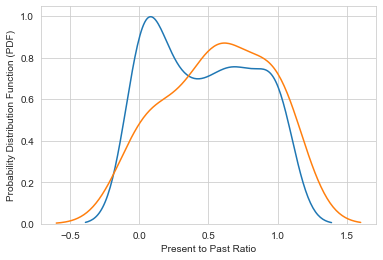

In [141]:
fig, ax = plt.subplots()
sns.distplot(lr, label='Liberal', hist=False)
sns.distplot(cr, label='Conservative', hist=False)
# ax.set_yscale('log')
# plt.xlim(1e0, 1e5)
# plt.ylim(0,1)
plt.xlabel("Present to Past Ratio")
plt.ylabel("Probability Distribution Function (PDF)")
plt.show()

<AxesSubplot:xlabel='political_identity', ylabel='pr_total_ratio'>

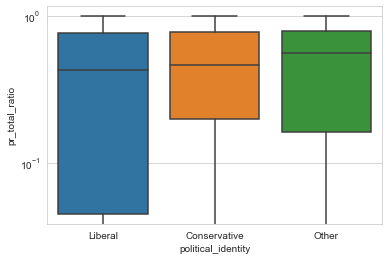

In [112]:
fig, ax = plt.subplots()
ax.set_yscale('log')
sns.boxplot(x='political_identity', y='pr_total_ratio', data=df)

In [113]:
# option 3
brokenness_score = []
for tense_list in df['total_tense']:
    if len(tense_list) == 0:
        brokenness_score.append(0)
    elif len(tense_list) == 1:
        brokenness_score.append(0)
    else:
        score = 0.0
        current_tense = tense_list[0][1]
        for tense in tense_list[1:]:
            if tense[1] != current_tense:
                score += 1
                current_tense = tense[1]
        brokenness_score.append(score / len(tense_list))

In [114]:
df['brokenness'] = brokenness_score

In [116]:
# option 5
total_sentiment = []
for atmosphere, feeling in zip(df['2016_atmosphere'], df['2016_feeling']):
    sentiment_list = []
    result = nlp.annotate(atmosphere, properties={'annotators': 'sentiment, pos', 'outputFormat': 'json'})
    result = json.loads(result)
    for sentence in result['sentences']:
        sentiment_list.append(sentence['sentiment'])
        result = nlp.annotate(feeling, properties={'annotators': 'sentiment, pos', 'outputFormat': 'json'})
        result = json.loads(result)
    for sentence in result['sentences']:
        sentiment_list.append(sentence['sentiment'])

    total_sentiment.append(sentiment_list)
    

In [117]:
df['sentiment'] = total_sentiment

In [118]:
qgrid_widget = qgrid.show_grid(df[['2016_atmosphere', '2016_feeling', 'sentiment']], show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## political leaning

### How to decide if a person is liberal or conservative?
- Here is one naive approach: 
    1. define a scale for political leaning for example from -7 to 7 (-7 most conservative, and 7 most liberal)
    2. categorize issues into liberal (1) and conservative (-1) 
        - Abortion Rights: 1
        - Public healthcare: 1
        - Strict gun control: 1
        - Strict immigration law: -1
        - LGBTQ rights: 1
        - Black live matters: 1
        - Climate change denials: -1
    3. set weight for each group for example 1 for for_group and -1 for against group
    4. obtain a measure for each person based on following $\sum\limits_{g}\sum\limits_{i} i\times g$ where $i$ is the issue score and $g$ is the group weight.
    5. set a threshold for decision for example 0


- Example: following setting would results in a measure of 2 for row 40
    - for_group: LGBTQ rights `1 * 1 = 1`
    - against_group: climate change denials `-1 * -1 = 1`
    - `final_score = 1 + 1 = 2`
    - if the threshold is 0 then this person is liberal.
- Question1: what do we do with undecided issues?
- Question2: can we add weights to different issues? for example *LGBTQ rights* could have more weight than *public strict immigration law*.

In [119]:
issue_weight = {'Public Healthcare': 1,
                'Black Lives Matter': 1,
                'Abortion Rights': 1,
                'Strict Gun Control': 1,
                'LGBTQ Rights': 1,
                'Strict Immigration Laws': -1,
                'Climate Change Denials': -1}

In [120]:
political_leaning_score = []
political_leaning = []
for fors, againsts in zip(df['for_group'], df['against_group']):
    score = 0
    try:
        for f in fors.split(','):
            score += issue_weight[f] * 1
        for a in againsts.split(','):
            score += issue_weight[a] * -1
    except AttributeError:
        pass
    political_leaning_score.append(score)
    if score >= 0:
        political_leaning.append('Liberal')
    else:
        political_leaning.append('Conservative')

In [121]:
df['political_leaning_score'] = political_leaning_score
df['political_leaning'] = political_leaning

### Relation between political_identity and political_leaning_score

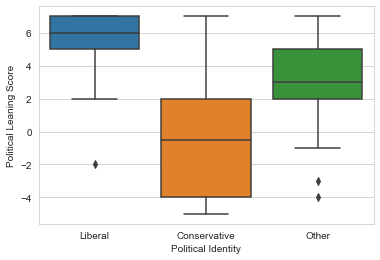

In [214]:
sns.boxplot(x='political_identity', y='political_leaning_score', data=df)
plt.xlabel("Political Identity")
plt.ylabel("Political Leaning Score")
plt.savefig('../plots/political_leaning_plot.png', format= 'png', dpi=300)

### observations:
- there is a positive correlation betweeen the self-reported political identity and the score we obtained.
- Those who recognize themselves as Conservatives, are all over the place in terms of critical issues.
- Those who identified themselves as Other, tend to be more Liberal.
- Using this approach number of conservatives would be very small

### relationship between political leaning and pr_pa_ratio

In [123]:
lr = df[df['political_leaning'] == 'Liberal']['pr_total_ratio']
lr_sorted = np.sort(lr)
plr = 1. * np.arange(len(lr)) / (len(lr) - 1)

cr = df[df['political_leaning'] == 'Conservative']['pr_total_ratio']
cr_sorted = np.sort(cr)
pcr = 1. * np.arange(len(cr)) / (len(cr) - 1)

/home/saed/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/saed/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


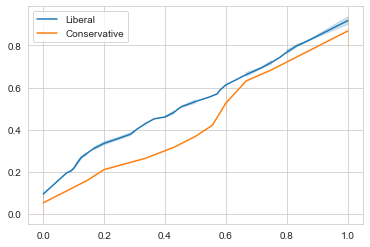

In [124]:
fig, ax = plt.subplots()
sns.lineplot(tuple(lr_sorted), plr, label='Liberal')
sns.lineplot(tuple(cr_sorted), pcr, label='Conservative')
#ax.set_xscale('log')
plt.show()

/home/saed/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/saed/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


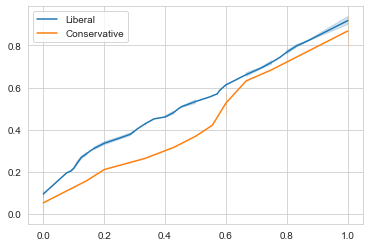

In [131]:
fig, ax = plt.subplots()
sns.lineplot(tuple(lr_sorted), plr, ax=ax, label='Liberal')
sns.lineplot(tuple(cr_sorted), pcr, ax=ax, label='Conservative')
#ax.set_xscale('log')
plt.show()
#fig.savefig('../plots/leaning_tense.png', format='png', dpi=300)

<AxesSubplot:xlabel='political_leaning', ylabel='pr_total_ratio'>

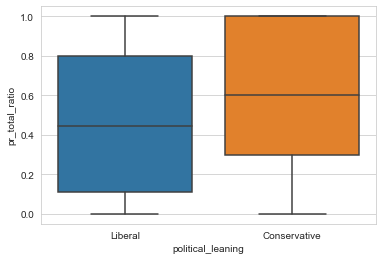

In [132]:
fig, ax = plt.subplots()
# ax.set_yscale('log')
sns.boxplot(x='political_leaning', y='pr_total_ratio', data=df)

In [133]:
from scipy import stats

In [134]:
stats.ks_2samp(lr_sorted, cr_sorted)

KstestResult(statistic=0.16666666666666666, pvalue=0.6440928544286291)

### relationship between political leaning and brokenness

<AxesSubplot:xlabel='political_leaning', ylabel='brokenness'>

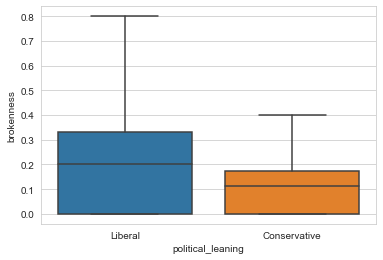

In [205]:
fig, ax = plt.subplots()
# ax.set_yscale('log')
sns.boxplot(x='political_leaning', y='brokenness', data=df)

In [206]:
lr = df[df['political_leaning'] == 'Liberal']['brokenness']
lr_sorted = np.sort(lr)
plr = 1. * np.arange(len(lr)) / (len(lr) - 1)

cr = df[df['political_leaning'] == 'Conservative']['brokenness']
cr_sorted = np.sort(cr)
pcr = 1. * np.arange(len(cr)) / (len(cr) - 1)


/home/saed/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/saed/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


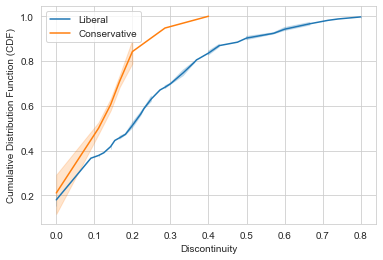

In [212]:
fig, ax = plt.subplots()
sns.lineplot(tuple(lr_sorted), plr, ax=ax, label='Liberal')
sns.lineplot(tuple(cr_sorted), pcr, ax=ax, label='Conservative')
plt.ylabel("Cumulative Distribution Function (CDF)")
plt.xlabel("Discontinuity")
plt.show()
fig.savefig ('../plots/brokenness_plt.png', format= 'png', dpi=300 )

In [208]:
stats.ks_2samp(lr_sorted, cr_sorted)

KstestResult(statistic=0.35454545454545455, pvalue=0.016602480198681158)